## Task

Develop an investment strategy for the Swiss equity market, backtest it using the provided datasets (`market_data.parquet`, `jkp_data.parquet`, `spi_index.csv`) and analyze its performance by benchmarking it against the SPI index. Work with the existing code infrastructure (`qpmwp-course`) and extend it by implementing any additional components needed for the strategy. Write a report that presents your methodology and the results.

### Coding (15 points)

- Selection:
  Implement selection item builder functions (via `SelectionItemBuilder`) to filter stocks based on specific criteria (e.g., exclude low-quality or high-volatility stocks).

- Optimization Data & Constraints:
  Implement functions to prepare optimization data (via `OptimizationItemBuilder`), including any econometric or machine learning-based predictions. These functions should also define optimization constraints (e.g., stock, sector, or factor exposure limits).

- Optimization Model:
  If you choose to create a custom optimization model, develop a class inheriting from Optimization (similar to `MeanVariance`, `LeastSquares`, or `BlackLitterman`). Your class should include methods set_objective and solve for defining the objective function and solving the optimization problem.

- Machine Learning Prediction:
  Integrate a machine learning model to estimate inputs for the optimization, such as expected returns or risk. This could include regression, classification, or learning-to-rank models. I suggest you to use the provided jkp_data as features, but you may also create your own (e.g., technical indicators computed on the return or price series).

- Simulation:
  Backtest the strategy and simulate portfolio returns. Account for fixed costs (1% per annum) and variable (transaction) costs (0.2% per rebalancing).


### Report (15 points):

Generate an HTML report with the following sections:

- High-level strategy overview: Describe the investment strategy you developed.

- Detailed explanation of the backtesting steps: Offer a more comprehensive breakdown of the backtesting process, including a description of the models implemented (e.g., details of the machine learning method used).

- Backtesting results:
    
    - Charts: Include visual representations (e.g., cumulative performance charts, rolling 3-year returns, etc.).
    - Descriptive statistics: Present key statistics such as mean, standard deviation, drawdown, turnover, and Sharpe ratio (or any other relevant metric) for the full backtest period as well as for subperiods (e.g., the last 5 years, or during bull vs. bear market phases).
    - Compare your strategy against the SPI index.

<Eric Björfors, 24-750-358, ericwilhelmsigvard.bjoerfors@uzh.ch>
<Miquel Muñoz García-Ramos, 24-750-911, miquel.munozgarcia-ramos@uzh.ch>
<Justus Krecker, 24-750-739, Karljustus.krecker@uzh.ch>
<Dani Nijboer, 24-750-960, danijariepeter.nijboer@uzh.ch>
<Valentino Orselli, 24-751-018, valentino.orselli@uzh.ch>


In [2]:
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
#src_path = os.path.join(project_root, 'qpmwp-course\\src')    #<Change this path if needed>
src_path = os.path.join(project_root, 'QUANT-PYTHON-LAST-ASSING', 'src')
sys.path.append(project_root)
sys.path.append(src_path)

'../data/'

'../data/'

In [7]:
# LSTM Mean–Variance Portfolio  ·  50 JKP factors 

#  deterministic μ (no MC-Dropout)
#  α-boost 1.8  +  turnover shrink 1.00 / 0.95
#  fixed λ = 1.5   (no dynamic rescale)

import os, sys, random, logging, warnings, types, itertools
from typing import Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#justus mac:




from helper_functions import load_data_spi
from estimation.covariance import Covariance
from optimization.optimization import MeanVariance, Objective
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest
from backtesting.backtest_item_builder_classes import SelectionItemBuilder, OptimizationItemBuilder
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume, bibfn_selection_gaps, bibfn_return_series,
    bibfn_budget_constraint, bibfn_box_constraints)
from qpsolvers import available_solvers

#  reproducibility and logging 
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

warnings.filterwarnings("ignore")

logging.basicConfig(level=logging.INFO,
                    
                    format="%(asctime)s %(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

sys.modules["xgboost"] = types.ModuleType("xgboost")   # qpsolvers workaround

# paths/dates

DATA_PATH  = '../data/'
START_DATE = "2016-01-01"
REB_PERIOD = 84 # quarterly
TRADING_DAYS = 252

# model and optimiser knobs
INIT_LAMBDA =  1.5 #1.5 before
ALPHA_BOOST   = 1.8 #1.8 before
GAMMA         = 0.002

HIDDEN, DROPOUT = 128, 0.3 #hidden state vector length, dropout rate? 
MAX_EPOCHS, PATIENCE = 100, 10 
LR, WD  = 1e-3, 1e-4 #Learnign rate, WD is? 
SEQ_LEN = 30   # look-back 30 days
FCAST_HORIZON = 1

TURN_SHRINK_LOW, TURN_SHRINK_HIGH = 1.00, 0.95
DISP_TH = 0.05

FIXED_ANNUAL, VC = 0.01, 0.002
FC = FIXED_ANNUAL * (REB_PERIOD / TRADING_DAYS)


#  50 JKP factors 
FUND_COLS = [
    
    "be_me", "op_at", "inv_gr1a", "ret_12_1", "beta_60m",
    
    "gp_at", "at_me", "rd_sale", "turnover_126d", "ivol_capm_252d", "f_score",
    
    "niq_be", "cash_at", "sale_gr1", "sale_gr3", "sale_me", "ocf_me",
    "netdebt_me", "gp_atl1", "op_atl1", "oaccruals_at", "taccruals_at",
    "capx_gr1", "capx_gr2", "capx_gr3", "inv_gr1", "rd_me", "rd5_at",
    "age", "tangibility", "kz_index", "ivol_ff3_21d", "ivol_hxz4_21d",
    "rvol_21d", "betadown_252d", "bidaskhl_21d", "rmax1_21d",
    "iskew_capm_21d", "coskew_21d", "turnover_var_126d", "dolvol_126d",
    "ami_126d", "zero_trades_252d", "corr_1260d", "rmax5_21d", "ret_6_1",
    "ret_9_1", "ret_12_7", "mispricing_mgmt", "qmj_growth"
]  

technical_features: pd.DataFrame = pd.DataFrame()

# helper to build tech panel 
def create_tech(ret: pd.DataFrame, vol: pd.DataFrame) -> pd.DataFrame:

    f, cum = pd.DataFrame(index=ret.index), (1+ret.fillna(0)).cumprod()
    for m in [1,3,6,12]:
        d=m*21; f[f"mom_{m}m"]=(cum/cum.shift(d)-1).mean(axis=1)

    for m in [1,3,6]:
        d=m*21; f[f"vol_{m}m"]=(ret.rolling(d,int(.7*d)).std().mean(axis=1)*np.sqrt(252))

    f["vol_trend"] = (vol.rolling(21,15).mean()/vol.rolling(63,45).mean()-1).mean(axis=1)
    f["breadth"]    = (ret>0).mean(axis=1)
    f["dispersion"] = ret.std(axis=1)

    return f.fillna(0)

class LSTMReturnPredictor(nn.Module):

    def __init__(self, inp:int, n:int):
        super().__init__()
        self.lstm=nn.LSTM(inp,HIDDEN,2,dropout=DROPOUT,batch_first=True)
        self.dp=nn.Dropout(DROPOUT); self.fc=nn.Linear(HIDDEN,n)

    def forward(self,x):
        out,_=self.lstm(x)
        return torch.tanh(self.fc(self.dp(out[:,-1,:])))*0.02

def pick_solver(pref="osqp"):
    solvers=available_solvers() if callable(available_solvers) else available_solvers
    return pref if pref in solvers else (solvers[0] if solvers else pref)

# optimisation class
class LSTMOptimization(MeanVariance):

    def __init__(self, **kw):
        super().__init__(solver_name=pick_solver(), **kw)
        self.net:Optional[LSTMReturnPredictor]=None
        self.input_dim:Optional[int]=None
        self.data:Optional[BacktestData]=None

    def _train(self,net,x,y):
        dev=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        net.to(dev); x,y=x.to(dev),y.to(dev)
        opt=torch.optim.AdamW(net.parameters(),lr=LR,weight_decay=WD)
        crit=nn.MSELoss(); best=np.inf; pat=0

        for epoch in range(MAX_EPOCHS):
            opt.zero_grad(); loss=crit(net(x),y); loss.backward(); opt.step()

            if loss.item()+1e-8<best: best,pat=loss.item(),0
            else:
                pat+=1
                if pat>=PATIENCE: break
        net.cpu()

    def _flat_funda(self,date,ids):
        jkp=self.data.jkp_data

        if jkp is None: return None
        dates=jkp.index.get_level_values(0).unique()
        idx=dates.searchsorted(date,side="right")-1

        if idx<0: return None
        eff=dates[idx]
        try: mat=jkp[FUND_COLS].xs(eff,level=0).loc[ids].fillna(0)
        except KeyError: return None
        mat=(mat-mat.mean())/mat.std().replace(0,1)
        logger.info("Fundamentals %s → %s | k=%d",eff.date(),date.date(),len(mat.columns))

        return mat.to_numpy().ravel()
    
    def set_objective(self,optimization_data):

        X=optimization_data["return_series"]; ids=X.columns.tolist()
        cov=self.covariance.estimate(X=X,inplace=False).fillna(0)
        tech=technical_features.reindex(X.index).fillna(0)
        reb=X.index[-1]; funda=self._flat_funda(reb,ids)

        seqs,tgt=[],[]

        for i in range(SEQ_LEN,len(X)-FCAST_HORIZON):
            blk=np.hstack([X.values[i-SEQ_LEN:i],tech.values[i-SEQ_LEN:i]])
            if funda is not None:
                blk=np.hstack([blk,np.repeat(funda[np.newaxis,:],SEQ_LEN,0)])
            seqs.append(blk); tgt.append(X.values[i+FCAST_HORIZON])
        mu=pd.Series(0.,index=ids)

        if len(seqs)>=50:
            x_t=torch.tensor(np.stack(seqs),dtype=torch.float32)
            y_t=torch.tensor(np.stack(tgt ),dtype=torch.float32)
            d=x_t.shape[-1]
            if (self.net is None) or (d!=self.input_dim):
                self.input_dim=d; self.net=LSTMReturnPredictor(d,len(ids))
            self._train(self.net,x_t,y_t)
            with torch.no_grad():
                mu_hat=self.net(torch.tensor(seqs[-1:],dtype=torch.float32)).cpu().numpy().flatten()
            mu=pd.Series(mu_hat,index=ids).clip(-0.05,0.05)

        sig=pd.Series(np.sqrt(np.diag(cov)),index=ids)
        mu=(mu/sig.pow(0.5)*ALPHA_BOOST).fillna(0)
        disp=technical_features.loc[reb,"dispersion"]
        mu*=TURN_SHRINK_LOW if disp<DISP_TH else TURN_SHRINK_HIGH

        lam=INIT_LAMBDA  
        P=cov.values*2*lam + np.eye(len(ids))*2*GAMMA
        self.objective=Objective(q=-mu,
                                 P=pd.DataFrame(P,index=ids,columns=ids))

# performance helper
def perf(ret,bench):
    df=pd.concat([ret.rename("LSTM"),bench.rename("SPI")],axis=1).dropna()
    cum=(1+df).cumprod(); out={}
    for c in df:
        r=df[c]; ar, av=r.mean()*252, r.std()*np.sqrt(252)
        dd=(cum[c]-cum[c].cummax())/cum[c].cummax()
        out[c]=[ar,av,ar/av if av>0 else np.nan,dd.min()]
    return pd.DataFrame(out,index=["AnnRet","AnnVol","Sharpe","MaxDD"]).T,cum

# back-test runner 
def run_backtest(plot=True):
    #portolio wights limirts
    upper = 0.05 #
    lower = 0.0 
    global technical_features
    data=BacktestData()
    data.market_data=pd.read_parquet(os.path.join(DATA_PATH,"market_data.parquet"))
    try: data.jkp_data=pd.read_parquet(os.path.join(DATA_PATH,"jkp_data.parquet"))
    except FileNotFoundError: data.jkp_data=None
    data.bm_series=load_data_spi(path=DATA_PATH)
    technical_features=create_tech(data.get_return_series(),
                                   data.get_volume_series())

    dates=data.market_data.index.get_level_values("date").unique().sort_values()
    rdates=dates[dates>=pd.to_datetime(START_DATE)][::REB_PERIOD]

    sel={"vol":SelectionItemBuilder(bibfn=bibfn_selection_min_volume,width=252,
                                    min_volume=500_000,agg_fn=np.median),
         "gaps":SelectionItemBuilder(bibfn=bibfn_selection_gaps,width=252,n_days=7)}
    opt={"ret":OptimizationItemBuilder(bibfn=bibfn_return_series,width=252,fill_value=0),
         "budget":OptimizationItemBuilder(bibfn=bibfn_budget_constraint,budget=1.0),
         "box":OptimizationItemBuilder(bibfn=bibfn_box_constraints,lower=lower,upper=upper)}

    optimization=LSTMOptimization()
    optimization.data=data
    bs=BacktestService(data=data,
                       selection_item_builders=sel,
                       optimization_item_builders=opt,
                       optimization=optimization,
                       rebdates=[d.strftime("%Y-%m-%d") for d in rdates])
    bt=Backtest(); bt.run(bs)

    sim=bt.strategy.simulate(return_series=data.get_return_series(),fc=FC,vc=VC)
    metrics,cum=perf(sim,data.bm_series)
    if plot:
        print("\nPerformance metrics\n"); print(metrics.round(4))
        cum.plot(figsize=(12,6),title="Cumulative return – LSTM vs SPI")
        plt.ylabel("Cumulative return"); plt.tight_layout(); plt.show()
    return metrics,cum

# CLI 
if __name__=="__main__":
    metrics, cum = run_backtest(plot=False)


Rebalancing date: 2016-01-01


2025-06-17 15:43:43,862 INFO: Fundamentals 2015-12-31 → 2016-01-01 | k=50


Rebalancing date: 2016-04-28


2025-06-17 15:43:51,527 INFO: Fundamentals 2016-03-31 → 2016-04-28 | k=50


Rebalancing date: 2016-08-24


2025-06-17 15:43:57,039 INFO: Fundamentals 2016-07-31 → 2016-08-24 | k=50


Rebalancing date: 2016-12-20


2025-06-17 15:44:05,323 INFO: Fundamentals 2016-11-30 → 2016-12-20 | k=50


Rebalancing date: 2017-04-17


2025-06-17 15:44:14,472 INFO: Fundamentals 2017-03-31 → 2017-04-17 | k=50


Rebalancing date: 2017-08-11


2025-06-17 15:44:20,978 INFO: Fundamentals 2017-07-31 → 2017-08-11 | k=50


Rebalancing date: 2017-12-07


2025-06-17 15:44:28,289 INFO: Fundamentals 2017-11-30 → 2017-12-07 | k=50


Rebalancing date: 2018-04-04


2025-06-17 15:44:38,102 INFO: Fundamentals 2018-03-31 → 2018-04-04 | k=50


Rebalancing date: 2018-07-31


2025-06-17 15:44:50,468 INFO: Fundamentals 2018-07-31 → 2018-07-31 | k=50


Rebalancing date: 2018-11-26


2025-06-17 15:45:01,549 INFO: Fundamentals 2018-10-31 → 2018-11-26 | k=50


Rebalancing date: 2019-03-22


2025-06-17 15:45:11,462 INFO: Fundamentals 2019-02-28 → 2019-03-22 | k=50


Rebalancing date: 2019-07-18


2025-06-17 15:45:20,392 INFO: Fundamentals 2019-06-30 → 2019-07-18 | k=50


Rebalancing date: 2019-11-13


2025-06-17 15:45:28,690 INFO: Fundamentals 2019-10-31 → 2019-11-13 | k=50


Rebalancing date: 2020-03-10


2025-06-17 15:45:36,643 INFO: Fundamentals 2020-02-29 → 2020-03-10 | k=50


Rebalancing date: 2020-07-06


2025-06-17 15:45:45,398 INFO: Fundamentals 2020-06-30 → 2020-07-06 | k=50


Rebalancing date: 2020-10-30


2025-06-17 15:45:53,588 INFO: Fundamentals 2020-09-30 → 2020-10-30 | k=50


Rebalancing date: 2021-02-25


2025-06-17 15:46:00,106 INFO: Fundamentals 2021-01-31 → 2021-02-25 | k=50


Rebalancing date: 2021-06-23


2025-06-17 15:46:10,453 INFO: Fundamentals 2021-05-31 → 2021-06-23 | k=50


Rebalancing date: 2021-10-19


2025-06-17 15:46:21,747 INFO: Fundamentals 2021-09-30 → 2021-10-19 | k=50


Rebalancing date: 2022-02-14


2025-06-17 15:46:32,278 INFO: Fundamentals 2022-01-31 → 2022-02-14 | k=50


Rebalancing date: 2022-06-10


2025-06-17 15:46:42,420 INFO: Fundamentals 2022-05-31 → 2022-06-10 | k=50


Rebalancing date: 2022-10-06


2025-06-17 15:46:50,855 INFO: Fundamentals 2022-09-30 → 2022-10-06 | k=50


Rebalancing date: 2023-02-01


2025-06-17 15:47:01,317 INFO: Fundamentals 2023-01-31 → 2023-02-01 | k=50


Rebalancing date: 2023-05-30


2025-06-17 15:47:10,866 INFO: Fundamentals 2023-04-30 → 2023-05-30 | k=50


Rebalancing date: 2023-09-25


2025-06-17 15:47:22,067 INFO: Fundamentals 2023-08-31 → 2023-09-25 | k=50


Rebalancing date: 2024-01-19


2025-06-17 15:47:36,636 INFO: Fundamentals 2023-12-31 → 2024-01-19 | k=50


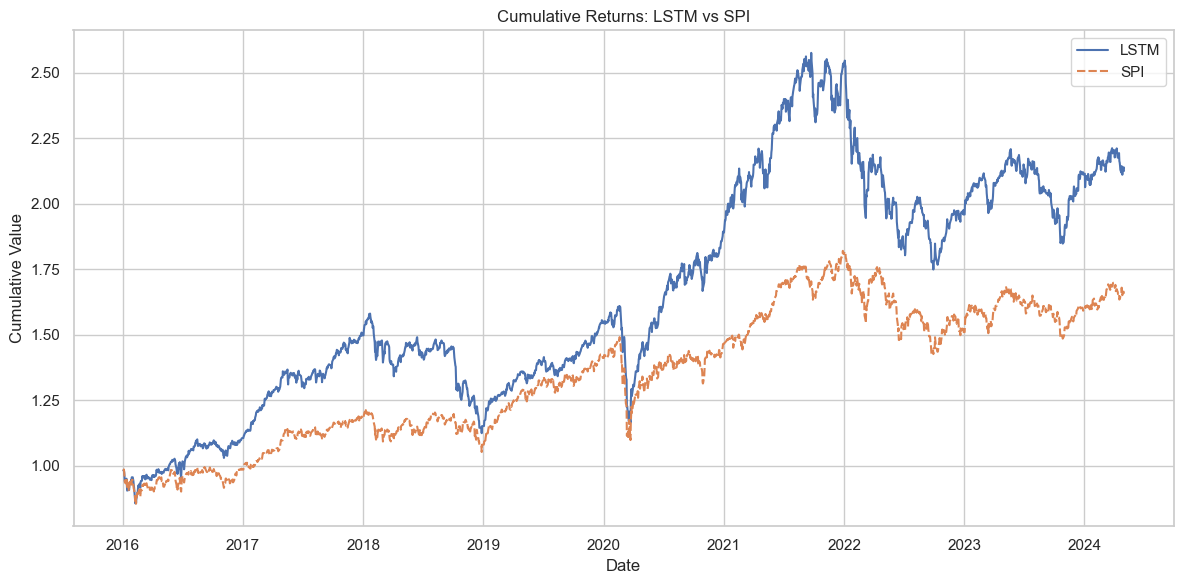

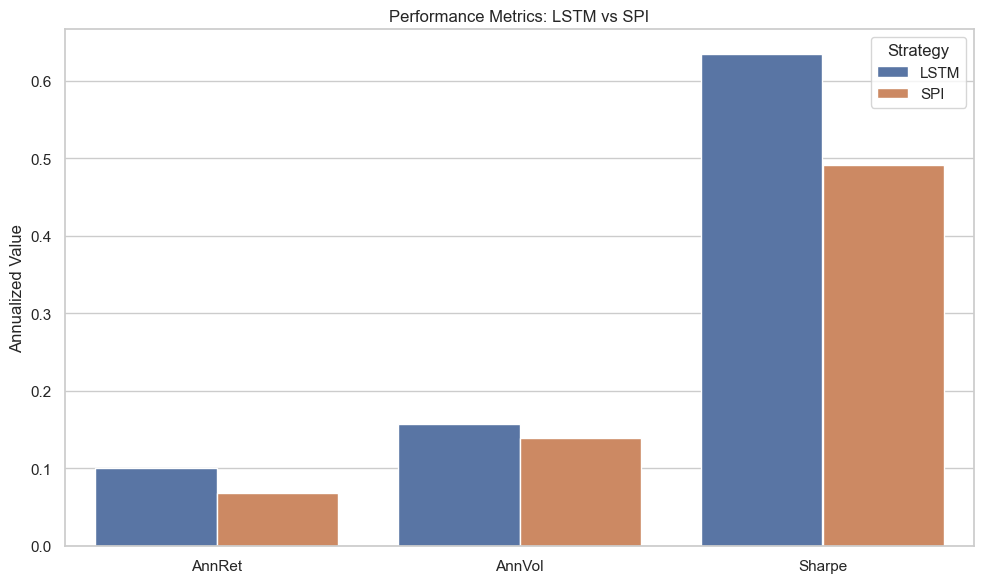

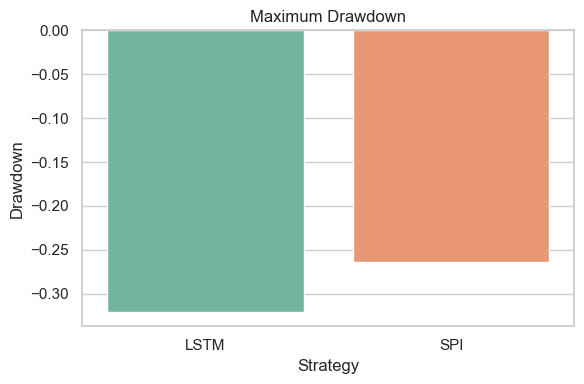

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure you have your `metrics` and `cum` DataFrames already defined
# metrics: DataFrame with rows = ["LSTM", "SPI"], columns = ["AnnRet", "AnnVol", "Sharpe", "MaxDD"]
# cum: DataFrame with cumulative returns over time for LSTM and SPI

sns.set(style="whitegrid")

# --- Plot 1: Cumulative Returns ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=cum)
plt.title("Cumulative Returns: LSTM vs SPI")
plt.ylabel("Cumulative Value")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


=== PERFORMANCE ANALYSIS WITH COMPREHENSIVE STATISTICS ===

1. FIXED PERIOD ANALYSIS

Analyzing period: Bear Market 2018 (2018-01-01 to 2018-12-31)
Found 261 observations


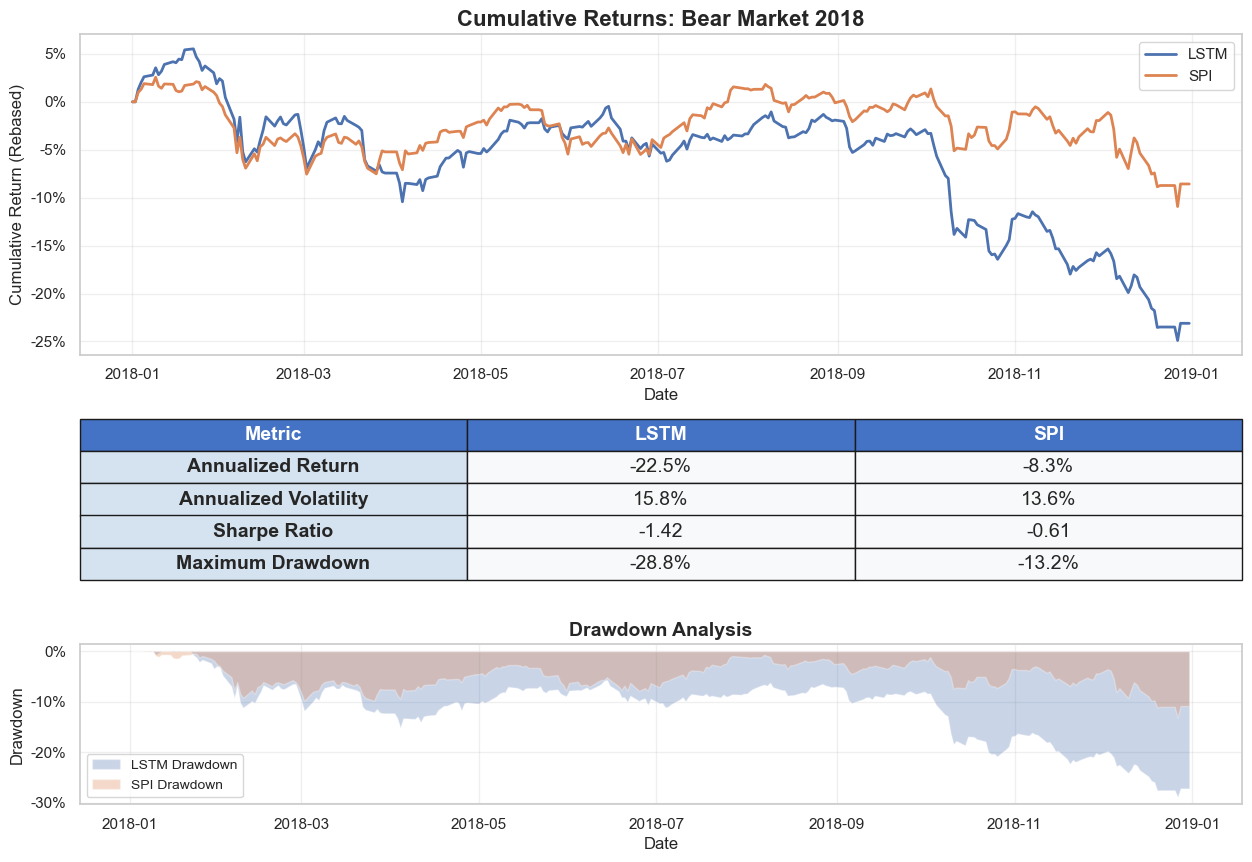


Analyzing period: Recovery 2019 (2019-01-01 to 2019-12-31)
Found 261 observations


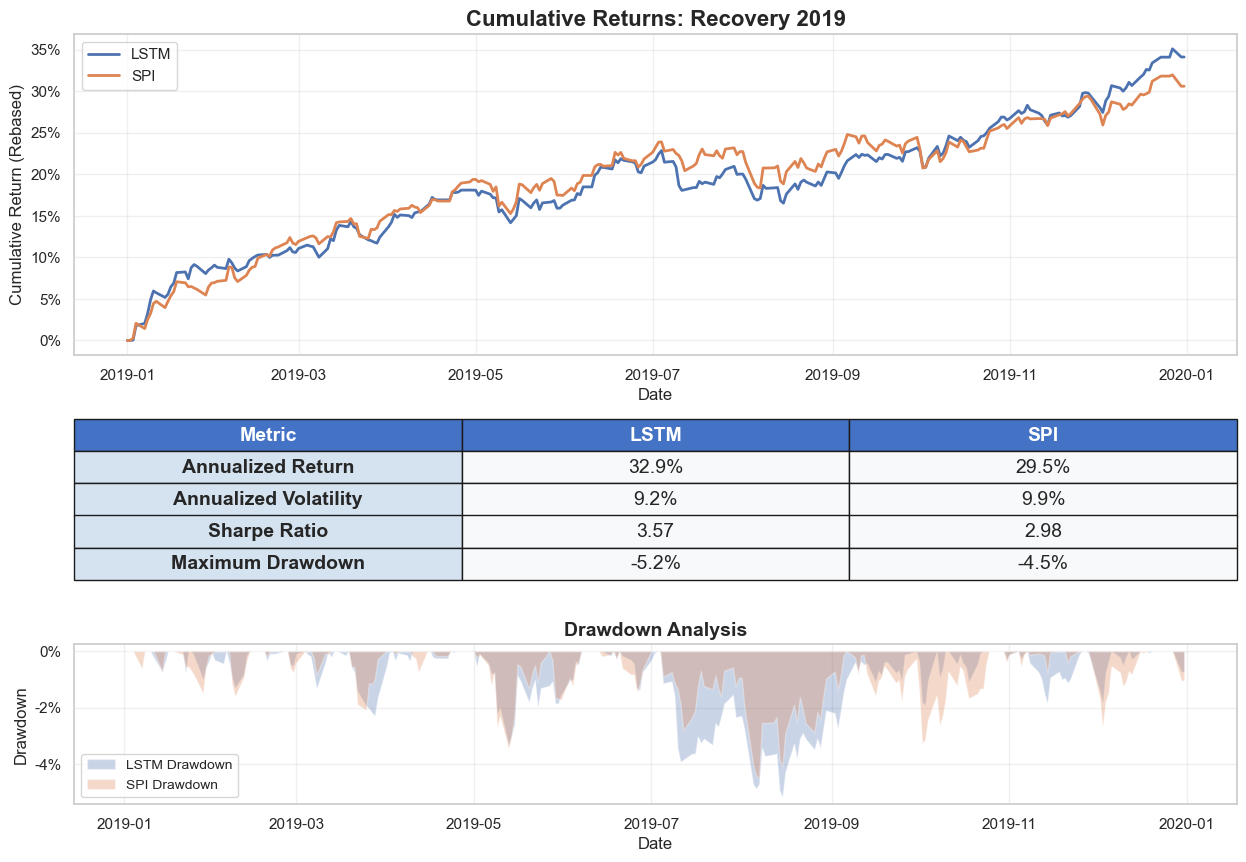


Analyzing period: COVID Crisis 2020 (2020-01-01 to 2020-12-31)
Found 262 observations


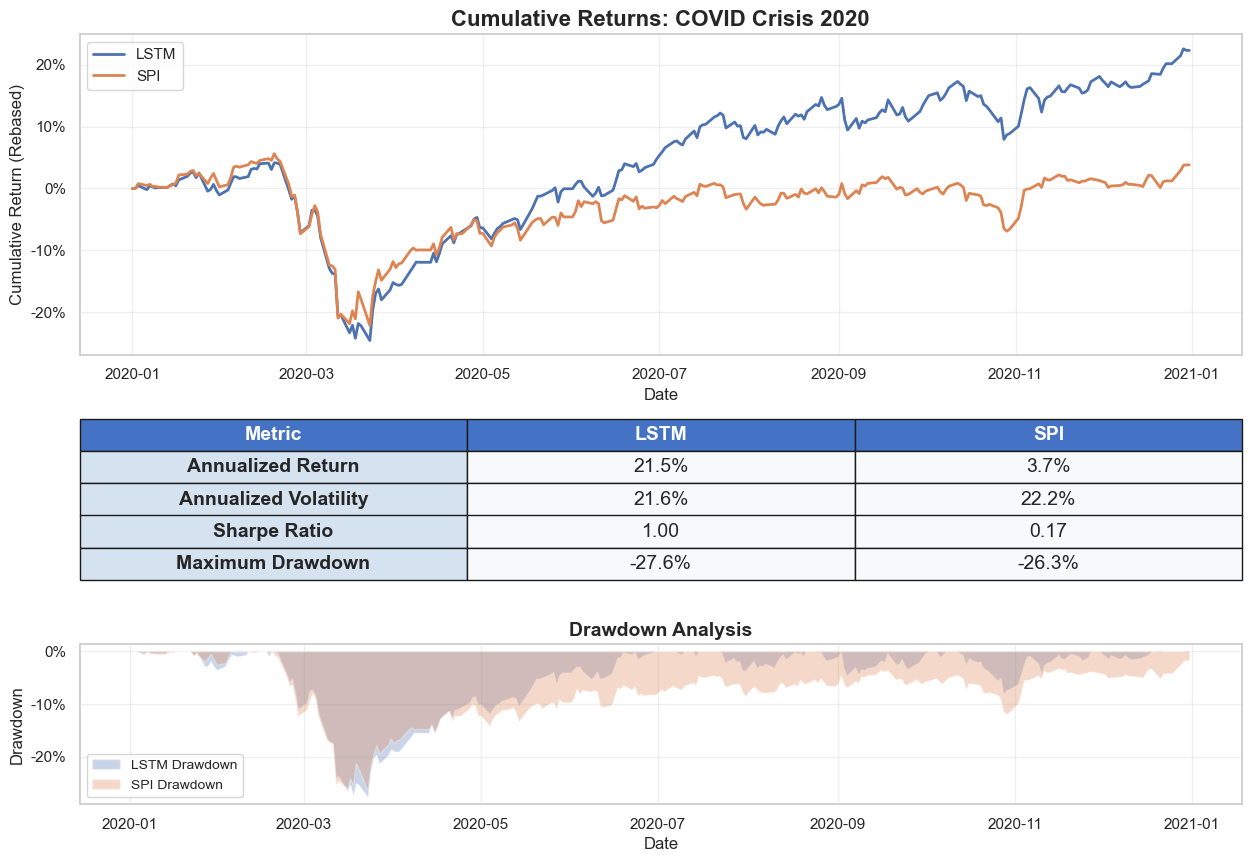


Analyzing period: Post-COVID 2021-2022 (2021-01-01 to 2022-12-31)
Found 521 observations


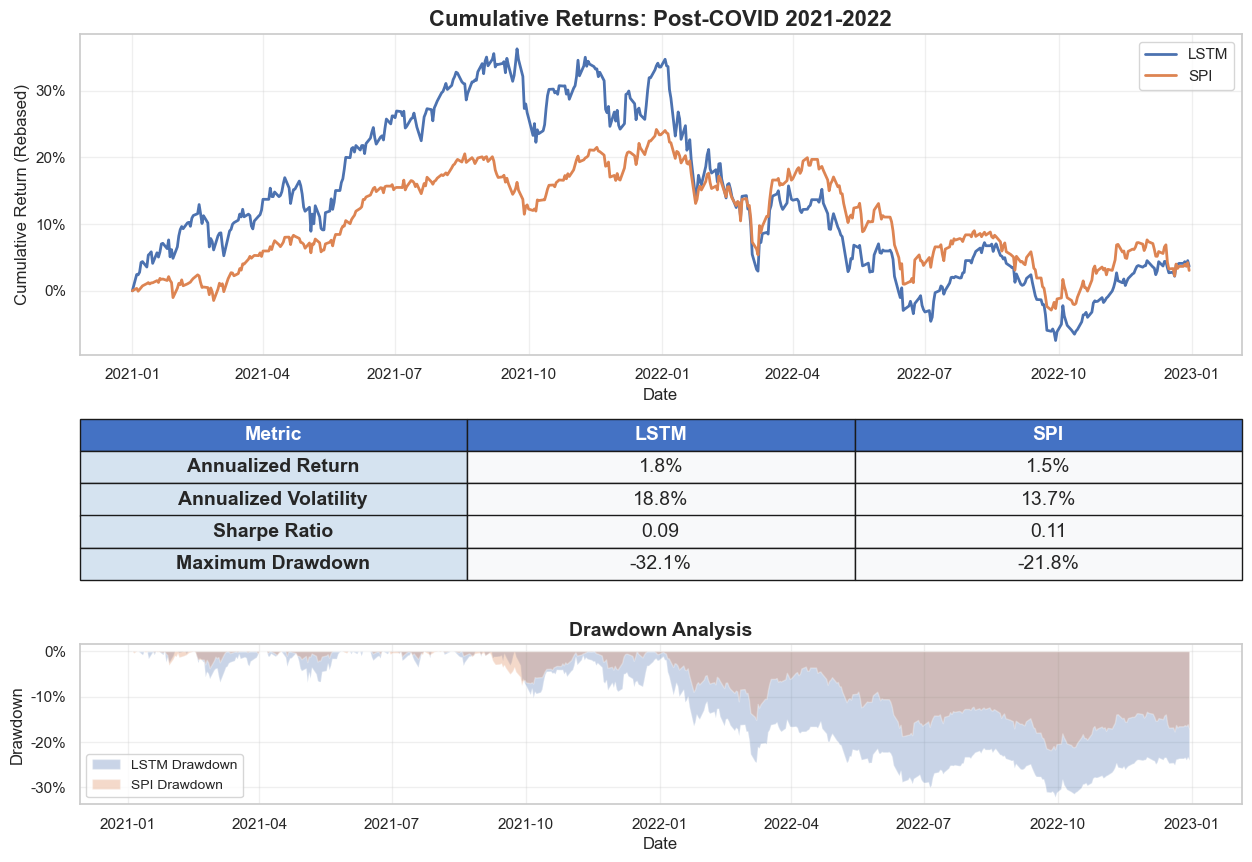


Analyzing period: Last 5 Years (2020-01-01 to 2024-12-31)
Found 1130 observations


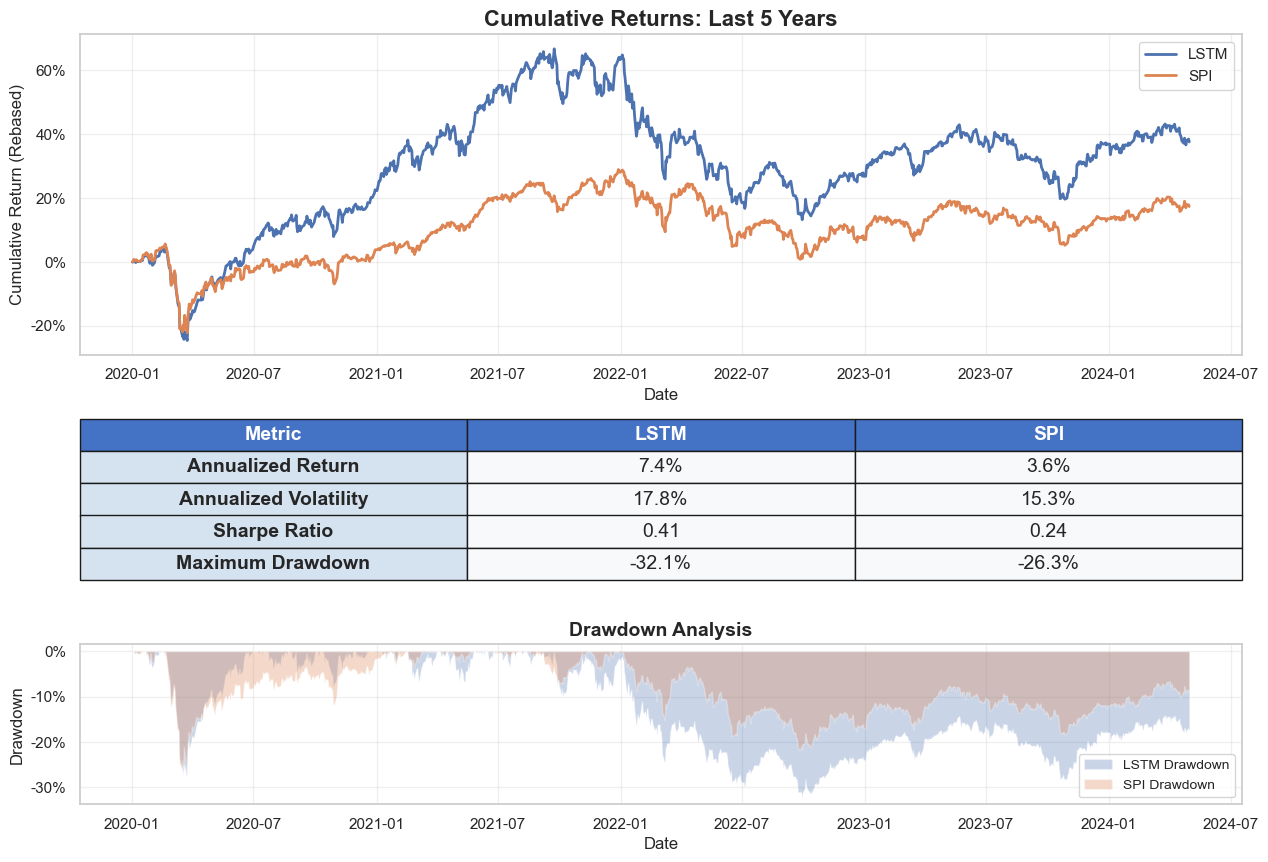



2. ROLLING 3-YEAR ANALYSIS

Analyzing rolling period: 2016–2019
Data points: 785


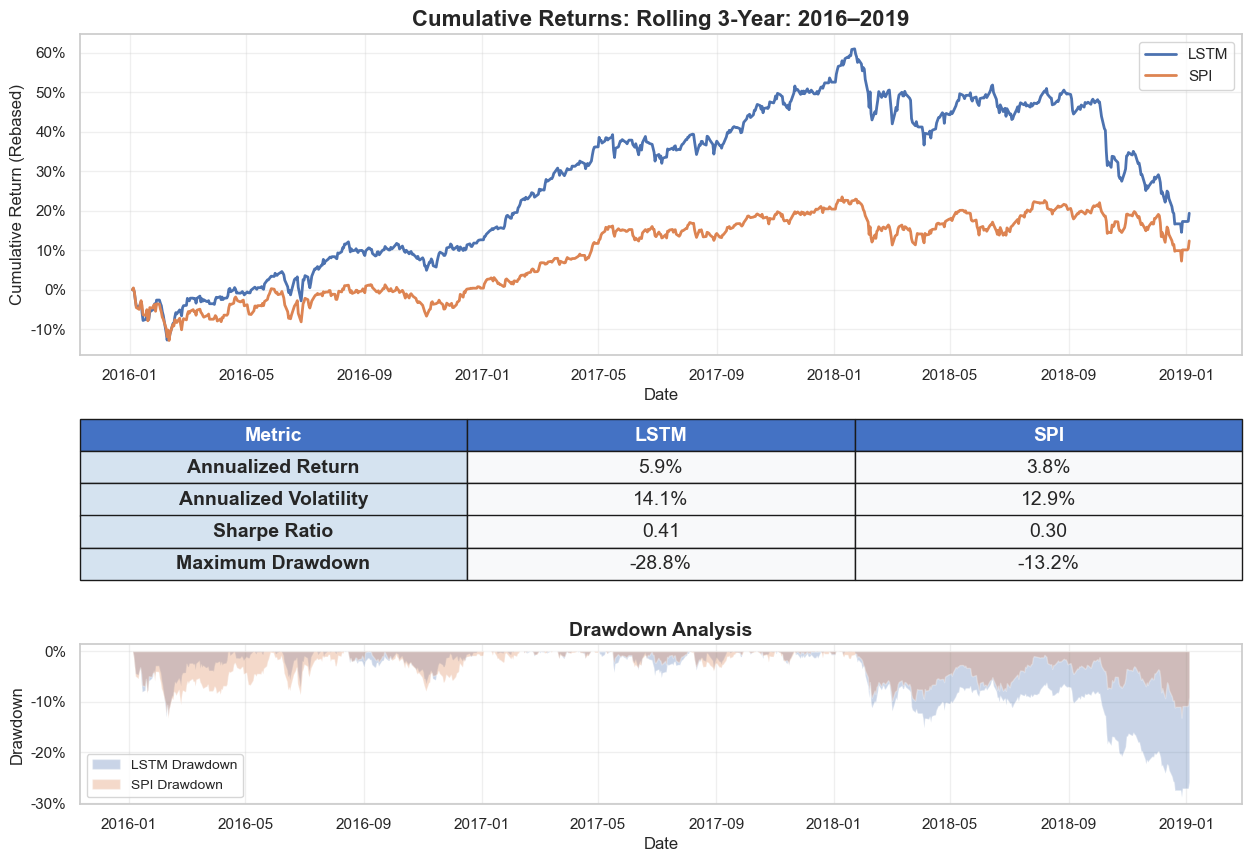


Analyzing rolling period: 2017–2020
Data points: 783


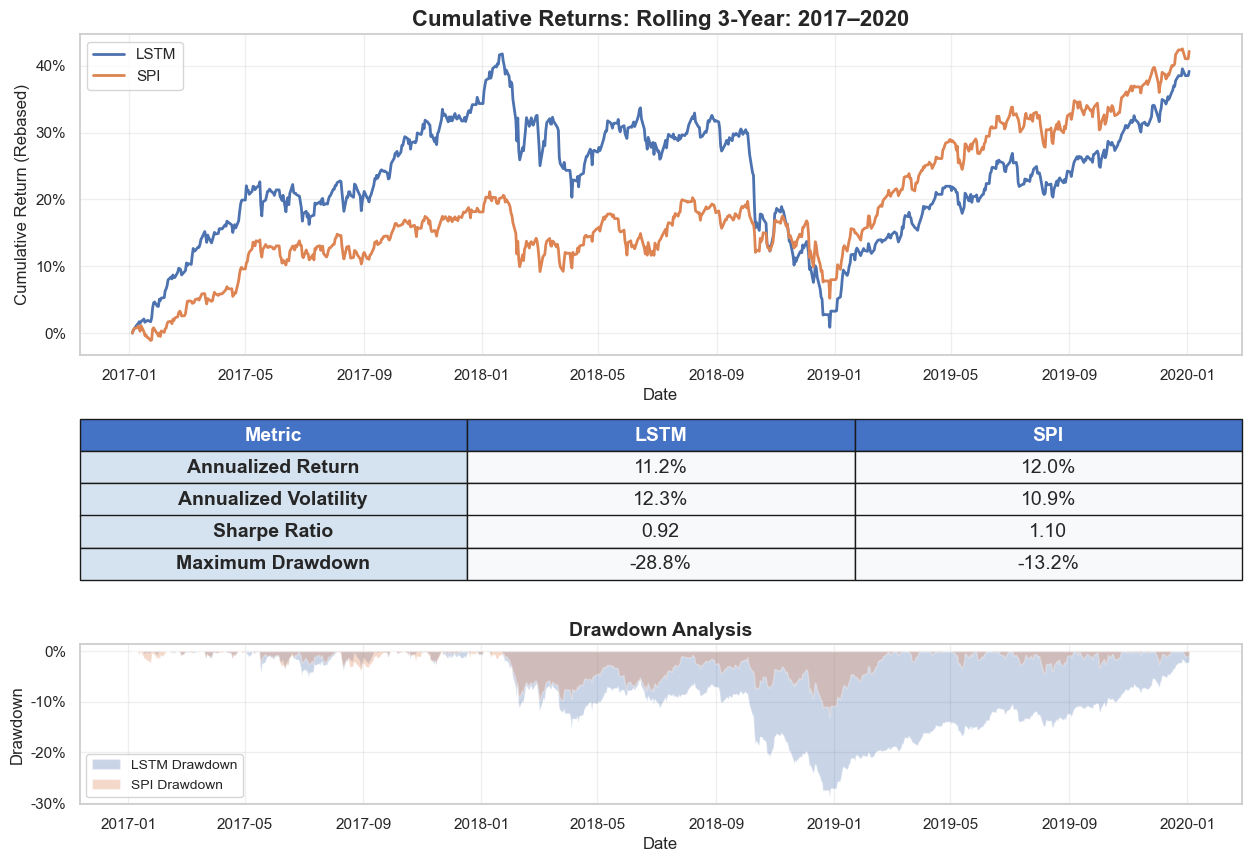


Analyzing rolling period: 2018–2021
Data points: 783


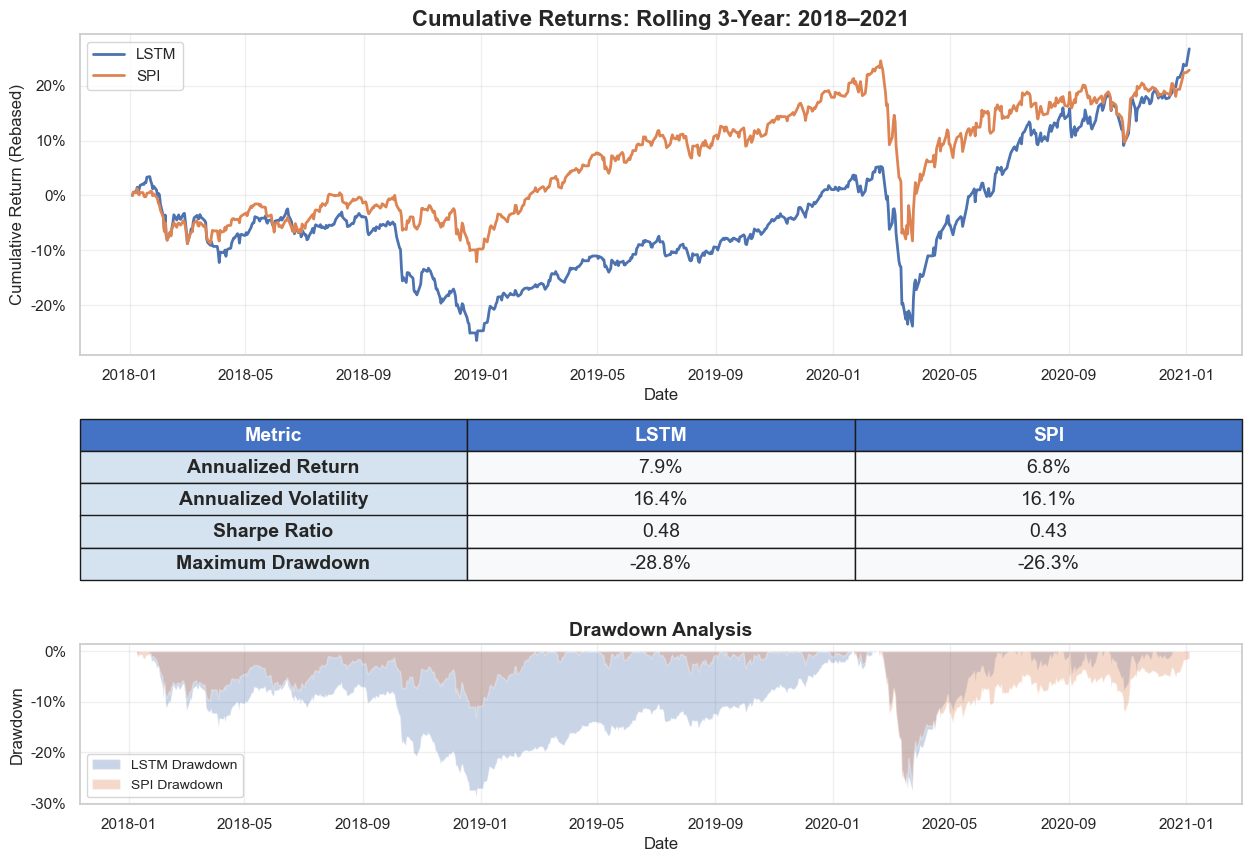


Analyzing rolling period: 2019–2022
Data points: 783


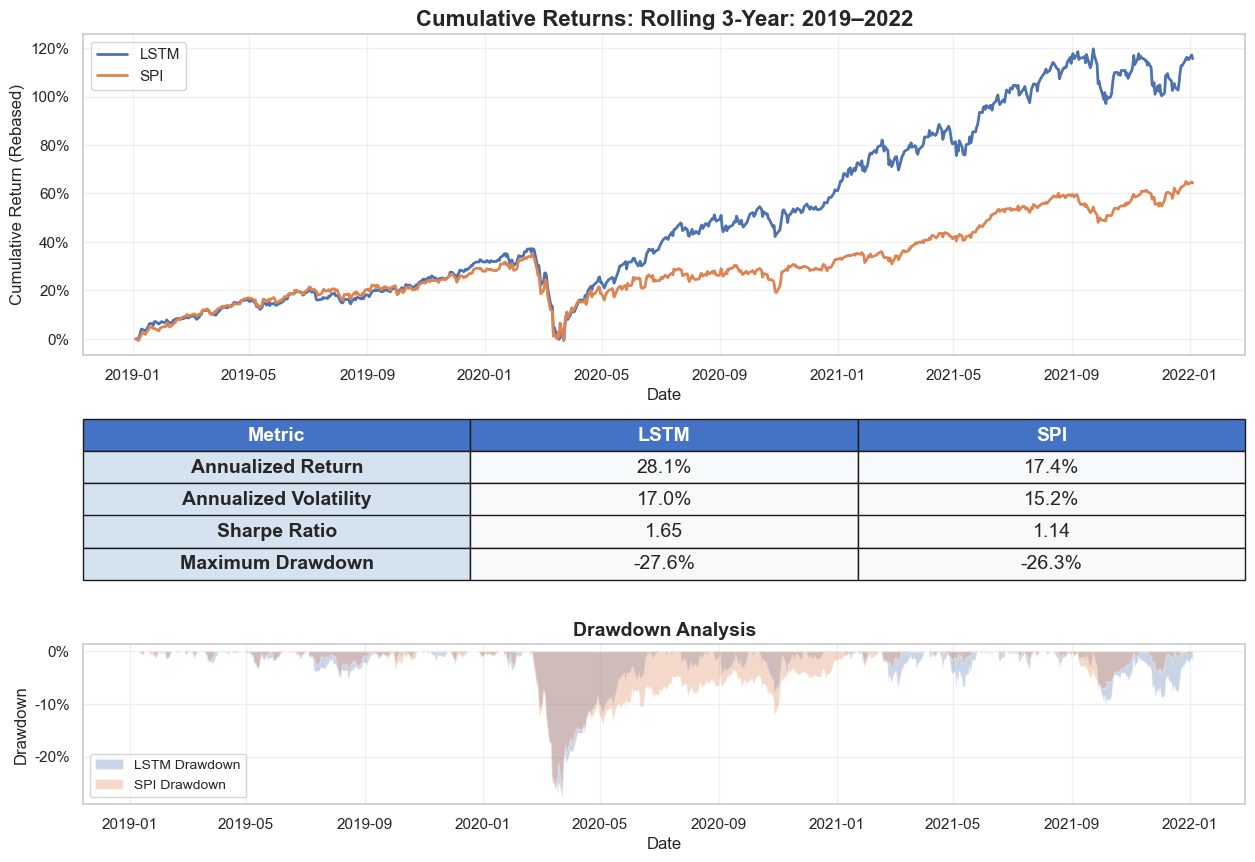


Analyzing rolling period: 2020–2023
Data points: 783


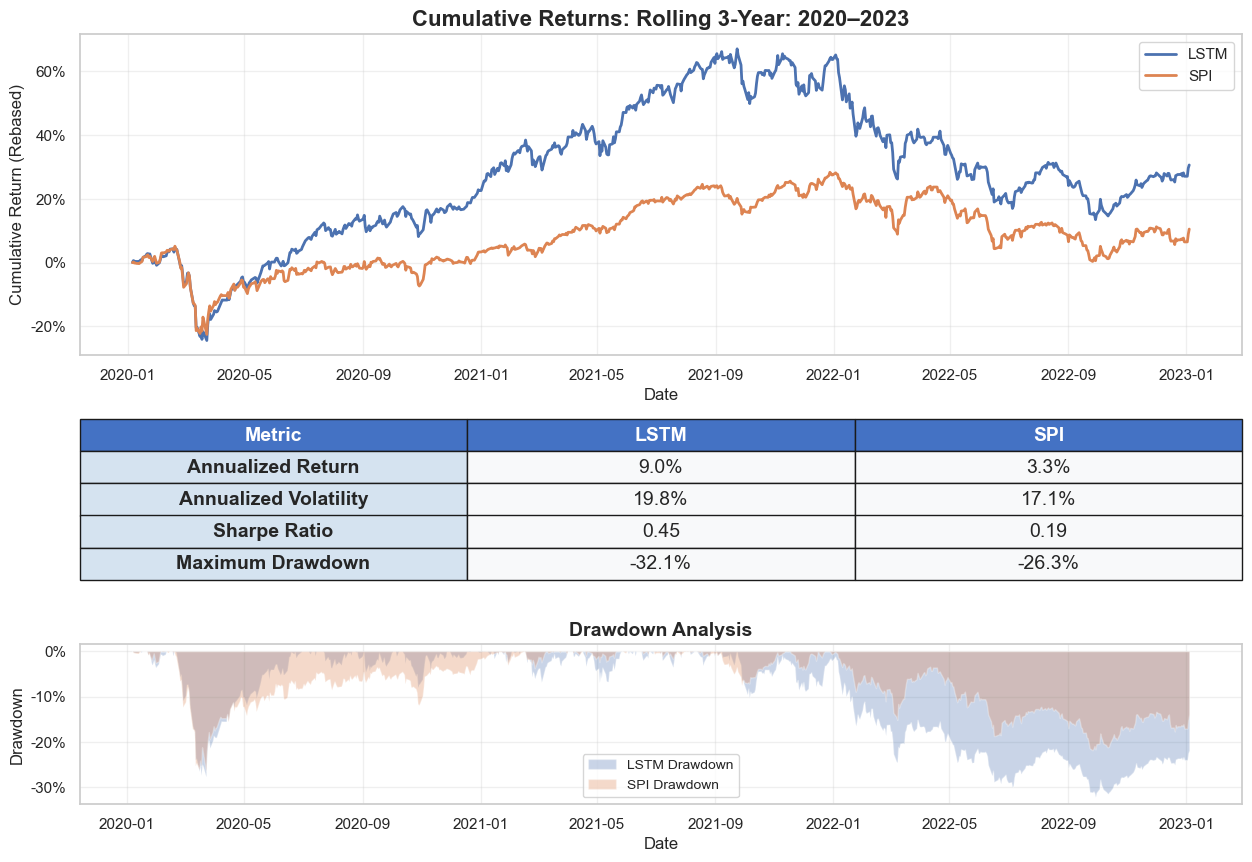


Analyzing rolling period: 2021–2024
Data points: 784


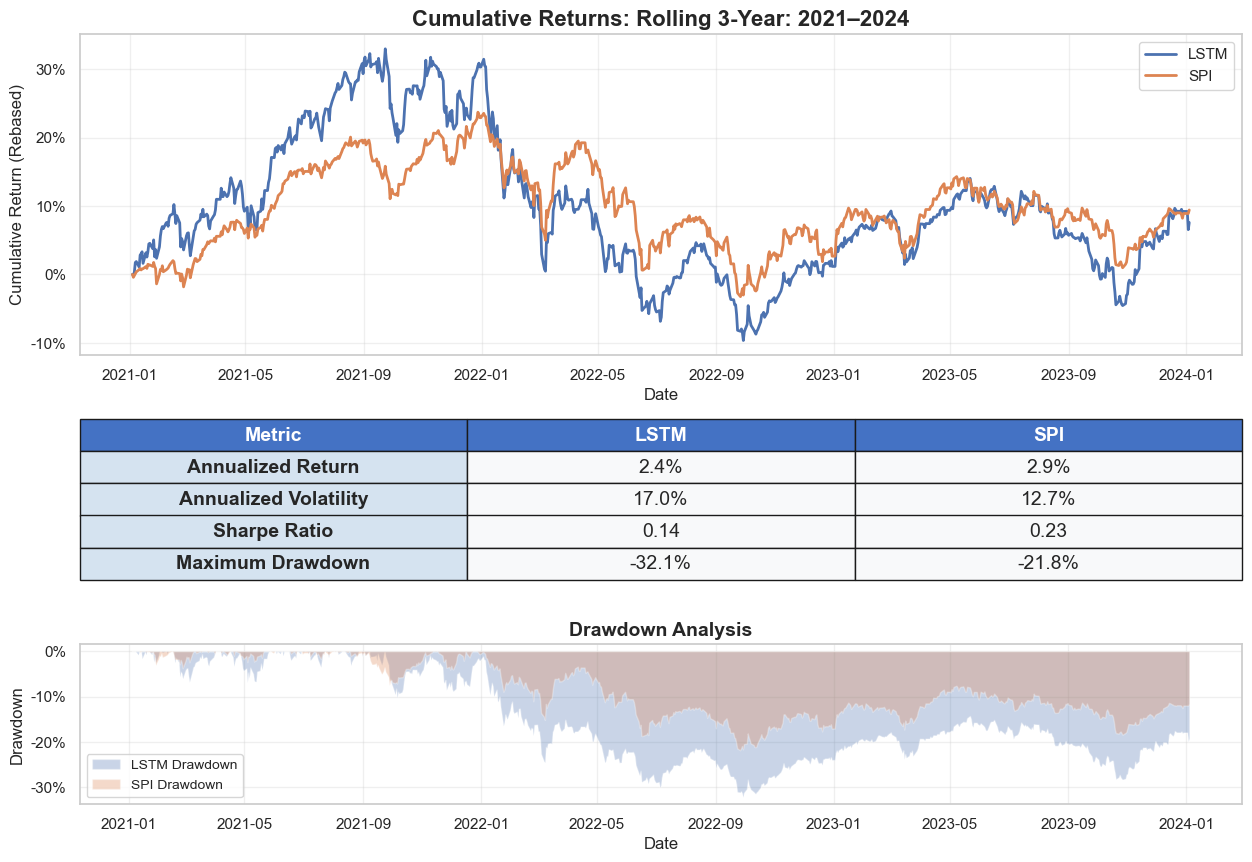



3. SUMMARY STATISTICS ACROSS ALL PERIODS
Summary of Key Metrics Across All Periods:
------------------------------------------------------------
     Analysis_Period Annualized Return Annualized Volatility Sharpe Ratio Maximum Drawdown
    Bear Market 2018            -22.5%                 15.8%        -1.42           -28.8%
       Recovery 2019             32.9%                  9.2%         3.57            -5.2%
   COVID Crisis 2020             21.5%                 21.6%         1.00           -27.6%
Post-COVID 2021-2022              1.8%                 18.8%         0.09           -32.1%
        Last 5 Years              7.4%                 17.8%         0.41           -32.1%
           2016–2019              5.9%                 14.1%         0.41           -28.8%
           2017–2020             11.2%                 12.3%         0.92           -28.8%
           2018–2021              7.9%                 16.4%         0.48           -28.8%
           2019–2022             2

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

def calculate_performance_stats(returns_series, period_name=""):
    """
    Calculate comprehensive performance statistics for a return series
    """
    # Convert to returns if cumulative
    if returns_series.iloc[0] != 1.0:  # If not rebased cumulative
        daily_returns = returns_series.pct_change().dropna()
    else:  # If rebased cumulative
        daily_returns = returns_series.pct_change().dropna()
    
    # Handle empty series
    if len(daily_returns) == 0:
        return {}
    
    # Basic statistics
    total_return = returns_series.iloc[-1] / returns_series.iloc[0] - 1
    ann_return = (1 + total_return) ** (252 / len(daily_returns)) - 1
    ann_vol = daily_returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Drawdown analysis
    cumulative = (1 + daily_returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_dd = drawdown.min()
    
    # Additional risk metrics
    skewness = stats.skew(daily_returns.dropna())
    kurtosis = stats.kurtosis(daily_returns.dropna())
    var_95 = np.percentile(daily_returns.dropna(), 5)
    
    # Positive/negative periods
    positive_days = (daily_returns > 0).mean()
    
    # Volatility of volatility (using 21-day rolling vol)
    rolling_vol = daily_returns.rolling(21).std() * np.sqrt(252)
    vol_of_vol = rolling_vol.std()
    
    stats_dict = {
        'Period': period_name,
        'Total Return': f"{total_return:.1%}",
        'Annualized Return': f"{ann_return:.1%}",
        'Annualized Volatility': f"{ann_vol:.1%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Maximum Drawdown': f"{max_dd:.1%}",

        'Days': len(daily_returns)
    }
    
    return stats_dict

def plot_performance_with_stats(data, title, start_date, end_date):
    """
    Plot cumulative performance and display statistics table
    """
    # Create subplot layout
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)
    
    # Main performance chart
    ax1 = fig.add_subplot(gs[0, :])
    
    # Rebase data to start at 1.0
    rebased = data / data.iloc[0]
    
    for column in rebased.columns:
        ax1.plot(rebased.index, rebased[column], label=column, linewidth=2)
    
    ax1.set_title(f"Cumulative Returns: {title}", fontsize=16, fontweight='bold')
    ax1.set_ylabel("Cumulative Return (Rebased)", fontsize=12)
    ax1.set_xlabel("Date", fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Format y-axis as percentage
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{(y-1)*100:.0f}%'))
    
    # Statistics table
    ax2 = fig.add_subplot(gs[1, :])
    ax2.axis('tight')
    ax2.axis('off')
    
    # Calculate stats for each series
    stats_list = []
    for column in data.columns:
        period_stats = calculate_performance_stats(data[column], column)
        stats_list.append(period_stats)
    
    # Create DataFrame for table
    if stats_list:
        stats_df = pd.DataFrame(stats_list)
        
        # Create table
        table_data = []
        metrics = ['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 
                  'Maximum Drawdown',]
        
        for metric in metrics:
            row = [metric] + [stats_df[stats_df['Period'] == col][metric].iloc[0] 
                             for col in data.columns]
            table_data.append(row)
        
        table = ax2.table(cellText=table_data,
                         colLabels=['Metric'] + list(data.columns),
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
        
        table.auto_set_font_size(False)
        table.set_fontsize(14)
        table.scale(1.8, 3.0)

        # Style the table
        for (i, j), cell in table.get_celld().items():
            if i == 0:
                cell.set_facecolor('#4472C4')
                cell.set_text_props(weight='bold', color='white')
            elif j == 0:
                cell.set_facecolor('#D5E3F0')
                cell.set_text_props(weight='bold')
            else:
                cell.set_facecolor('#F8F9FA')
    
    # Drawdown chart
    ax3 = fig.add_subplot(gs[2, :])
    
    for column in data.columns:
        returns = data[column].pct_change().dropna()
        cumulative = (1 + returns).cumprod()
        rolling_max = cumulative.expanding().max()
        drawdown = (cumulative - rolling_max) / rolling_max
        
        ax3.fill_between(drawdown.index, drawdown, 0, alpha=0.3, label=f'{column} Drawdown')
    
    ax3.set_title("Drawdown Analysis", fontsize=14, fontweight='bold')
    ax3.set_ylabel("Drawdown", fontsize=12)
    ax3.set_xlabel("Date", fontsize=12)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# -------- MAIN ANALYSIS -------- #

# Assume 'cum' is your cumulative returns DataFrame with LSTM and SPI columns
# Make sure cum is defined and properly formatted

print("=== PERFORMANCE ANALYSIS WITH COMPREHENSIVE STATISTICS ===\n")

# -------- Fixed Intervals -------- #
print("1. FIXED PERIOD ANALYSIS")
print("=" * 50)

intervals = {
    "Bear Market 2018": ("2018-01-01", "2018-12-31"),
    "Recovery 2019": ("2019-01-01", "2019-12-31"), 
    "COVID Crisis 2020": ("2020-01-01", "2020-12-31"),
    "Post-COVID 2021-2022": ("2021-01-01", "2022-12-31"),
    "Last 5 Years": ("2020-01-01", "2024-12-31")
}

all_period_stats = []

for label, (start, end) in intervals.items():
    print(f"\nAnalyzing period: {label} ({start} to {end})")
    
    try:
        subset = cum.loc[start:end]
        if not subset.empty and len(subset) > 5:  # Ensure we have enough data
            print(f"Found {len(subset)} observations")
            stats_df = plot_performance_with_stats(subset, label, start, end)
            
            # Add period identifier to stats
            stats_df['Analysis_Period'] = label
            all_period_stats.append(stats_df)
            
        else:
            print(f"Insufficient data for period {label}")
            
    except Exception as e:
        print(f"Error processing period {label}: {e}")

# -------- Rolling 3-Year Analysis -------- #
print("\n\n2. ROLLING 3-YEAR ANALYSIS")
print("=" * 50)

rolling_years = 3
rolling_stats = []

# Get available date range
start_date = cum.index.min()
end_date = cum.index.max()

# Create rolling 3-year periods
current_start = start_date
while current_start + pd.DateOffset(years=rolling_years) <= end_date:
    period_end = current_start + pd.DateOffset(years=rolling_years)
    
    # Format period label
    period_label = f"{current_start.year}–{period_end.year}"
    
    try:
        subset = cum.loc[current_start:period_end]
        if not subset.empty and len(subset) > 100:  # Ensure meaningful data
            print(f"\nAnalyzing rolling period: {period_label}")
            print(f"Data points: {len(subset)}")
            
            stats_df = plot_performance_with_stats(
                subset, 
                f"Rolling 3-Year: {period_label}",
                current_start.strftime('%Y-%m-%d'),
                period_end.strftime('%Y-%m-%d')
            )
            
            # Add period info
            stats_df['Analysis_Period'] = period_label
            stats_df['Period_Type'] = 'Rolling_3Y'
            rolling_stats.append(stats_df)
            
    except Exception as e:
        print(f"Error processing rolling period {period_label}: {e}")
    
    # Move to next year
    current_start = current_start + pd.DateOffset(years=1)

# -------- Summary Statistics -------- #
print("\n\n3. SUMMARY STATISTICS ACROSS ALL PERIODS")
print("=" * 60)

if all_period_stats or rolling_stats:
    # Combine all statistics
    all_stats = []
    if all_period_stats:
        all_stats.extend(all_period_stats)
    if rolling_stats:
        all_stats.extend(rolling_stats)
    
    if all_stats:
        combined_stats = pd.concat(all_stats, ignore_index=True)
        
        # Create summary table
        print("Summary of Key Metrics Across All Periods:")
        print("-" * 60)
        
        # Focus on LSTM strategy performance
        lstm_stats = combined_stats[combined_stats['Period'] == 'LSTM'].copy()
        
        if not lstm_stats.empty:
            summary_table = lstm_stats[['Analysis_Period', 'Annualized Return', 
                                       'Annualized Volatility', 'Sharpe Ratio', 
                                       'Maximum Drawdown']].copy()
            
            print(summary_table.to_string(index=False))
            
            # Calculate average performance metrics
            print(f"\n{'='*60}")
            print("LSTM STRATEGY - AVERAGE PERFORMANCE ACROSS PERIODS:")
            print(f"{'='*60}")
            
            # Convert percentage strings back to numbers for averaging
            def pct_to_float(pct_str):
                try:
                    return float(pct_str.strip('%')) / 100
                except:
                    return np.nan
            
            def ratio_to_float(ratio_str):
                try:
                    return float(ratio_str)
                except:
                    return np.nan
            
            avg_return = lstm_stats['Annualized Return'].apply(pct_to_float).mean()
            avg_vol = lstm_stats['Annualized Volatility'].apply(pct_to_float).mean()
            avg_sharpe = lstm_stats['Sharpe Ratio'].apply(ratio_to_float).mean()
            avg_dd = lstm_stats['Maximum Drawdown'].apply(pct_to_float).mean()
            
            print(f"Average Annualized Return:    {avg_return:.1%}")
            print(f"Average Annualized Volatility: {avg_vol:.1%}")
            print(f"Average Sharpe Ratio:         {avg_sharpe:.2f}")
            print(f"Average Maximum Drawdown:     {avg_dd:.1%}")
            
            # Best and worst periods
            returns_numeric = lstm_stats['Annualized Return'].apply(pct_to_float)
            best_period_idx = returns_numeric.idxmax()
            worst_period_idx = returns_numeric.idxmin()
            
            print(f"\nBest Period: {lstm_stats.loc[best_period_idx, 'Analysis_Period']} "
                  f"({lstm_stats.loc[best_period_idx, 'Annualized Return']})")
            print(f"Worst Period: {lstm_stats.loc[worst_period_idx, 'Analysis_Period']} "
                  f"({lstm_stats.loc[worst_period_idx, 'Annualized Return']})")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Save results to CSV for further analysis
if all_period_stats or rolling_stats:
    all_stats_combined = pd.concat(all_stats, ignore_index=True) if all_stats else pd.DataFrame()
    
    if not all_stats_combined.empty:
        all_stats_combined.to_csv('strategy_performance_analysis.csv', index=False)
        print(f"Results saved to 'strategy_performance_analysis.csv'")
        print(f"Total analysis periods: {len(all_stats_combined['Analysis_Period'].unique())}")